# Model creation

In [33]:
# Установка версий программных пакетов
!pip install -qr ../requirements.txt

В результате проверки результатов обучения моделей разными участниками было выявлено их расхождение при тождественности параметров. Такое несоответствие [происходит](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras) вследствие использования библиотеками Numpy и TensorFlow случайных чисел в генераторах псевдослучайных значений. Для воспроизодимости результатов обучения в VS Code зафиксируем seed,- начальное значение генератора псевдослучайных чисел.

In [34]:
# Импортируем библиотеки
import mne
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile

# графические библиотеки
from matplotlib import pyplot as plt
%matplotlib widget
import os

# Зафиксируем PYTHONHASHSEED для воспроиизводимости результатов обучения модели
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Логгирование процесса
from comet_ml import Experiment

# библиотеки машинного обучения
import tensorflow as tf
from tensorflow import keras
#from keras import backend as K
#from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import layers

import random

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Скрытие хода обучения модели,который загромождает ноутбук
from IPython.display import clear_output

In [35]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')
from utils.functions import config_reader, f1, callbacks, reset_random_seeds
from utils import figures 

# Импортируем константы из файла config
config = config_reader('../config/data_config.json') 

# Импортируем модели
from models.models import SimpleRNN_Model, LSTM_Model

In [36]:
# credentials = config_reader('../config/credentials.json')
# experiment = Experiment(
#     api_key = credentials.api_key, 
#     project_name = credentials.project_name,
#     workspace = credentials.workspace,
# );  
# experiment.set_name('model') # имя эксперимента

In [37]:
# константы и глобальные параметры данных
# Все исходные файлы размещены в папке data
PATH = '/gesture_classification/data/'

# Папка для сохранения весов лучшей модели при обучении (исп-ся в ModelCheckpoint в функции callbacks)
PATH_TEMP_MODEL = '/gesture_classification/models/temp_best_model'

if not os.path.exists(PATH_TEMP_MODEL):
    os.mkdir(PATH_TEMP_MODEL)    

# Папка для сохранения обученных моделей для последующего предсказания
PATH_FOR_MODEL = '/gesture_classification/models'

if not os.path.exists(PATH_FOR_MODEL):
    os.mkdir(PATH_FOR_MODEL) 

In [38]:
# 1. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(seed_value)

# 4. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [39]:
# # Проверим воспроизводимость результата случайного распределения 
# model = keras.Sequential( [ 
# layers.Dense(2,name = 'one'),
# layers.Dense(3,activation = 'sigmoid', name = 'two'),
# layers.Dense(2,name = 'three')])

# x = tf.random.uniform((12,12))
# print(model(x))

# print()

Результат вычислений должен совпадать:
```
tf.Tensor(
[[ 0.84417915 -0.09455603]
 [ 0.6749006  -0.13408634]
 [ 0.68973166 -0.14211544]
 [ 0.71698654 -0.13607895]
 [ 0.68233585 -0.15881413]
 [ 0.6576998  -0.15178624]
 [ 0.703879   -0.13622592]
 [ 0.7794712  -0.12639348]
 [ 0.8378607  -0.11526634]
 [ 0.7633468  -0.1148871 ]
 [ 0.8343782  -0.09699636]
 [ 0.79229456 -0.12571578]], shape=(12, 2), dtype=float32)

```

### Read Data

In [40]:
# Создадим словарь для агрегации данных. Импортируем его структуру (ключи и названия файлов в архиве) из конфига
# Поскольку ключи словаря в конфиге могут находиться только в строковом формате (str),
# то для удобства переведём их в целочисленный (int)

mounts = config.mounts.toDict()

for i in mounts.keys():
    mounts[int(i)] = mounts.pop(i)
mounts.keys()

dict_keys([1, 2, 3])

In [41]:
# Чтение данных из архива (без распаковки архива)
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(f"Количество наблюдений пилота {mount_name}: {len(mount['X_test_dataset'])}")

Количество наблюдений пилота 1: 899
Количество наблюдений пилота 2: 855
Количество наблюдений пилота 3: 861


In [42]:
# Чтение sample_submission.csv из архива (без распаковки архива)
with ZipFile(path_to_zip) as myzip:
    y_test = pd.read_csv(myzip.open('sample_submission.csv'))

y_test[['subject_id', 'sample', 'timestep']] = (
    y_test['subject_id-sample-timestep']
    .str.split('-', 2, expand=True)
    .astype(int)
)

print(f"размерность y_test {y_test.shape}")
display(y_test.head())
# y_test.set_index(['subject_id', 'sample'])

y_test.groupby(['subject_id'])['sample'].nunique()

размерность y_test (471610, 5)


subject_id-sample-timestep  class  subject_id  sample  timestep
0                      1-0-0      4           1       0         0
1                      1-0-1      2           1       0         1
2                      1-0-2      0           1       0         2
3                      1-0-3      0           1       0         3
4                      1-0-4      3           1       0         4

subject_id
1    899
2    855
3    861
Name: sample, dtype: int64

In [49]:
# Эта ячейка нужна для проверки размерности данных
mounts[1]['X_train'].shape

(24030, 50)

Отобразим тренировочные данные: показания датчиков и классы жестов.

Логгируем исходные данные


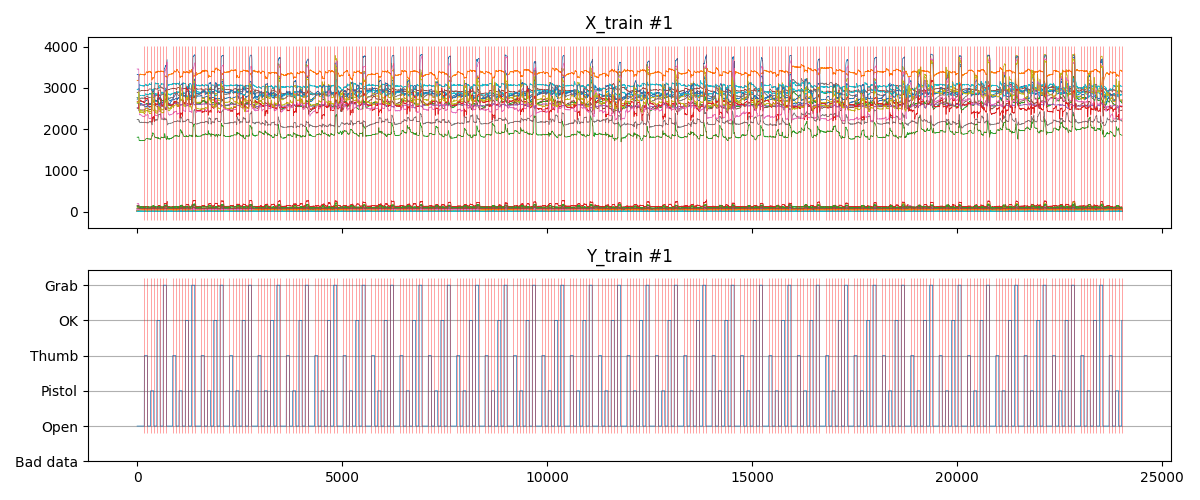

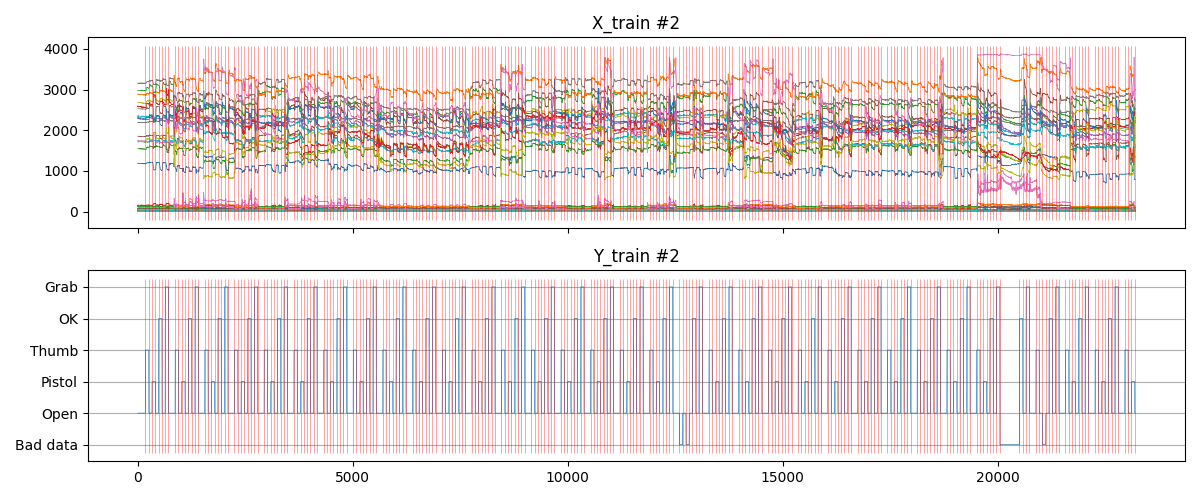

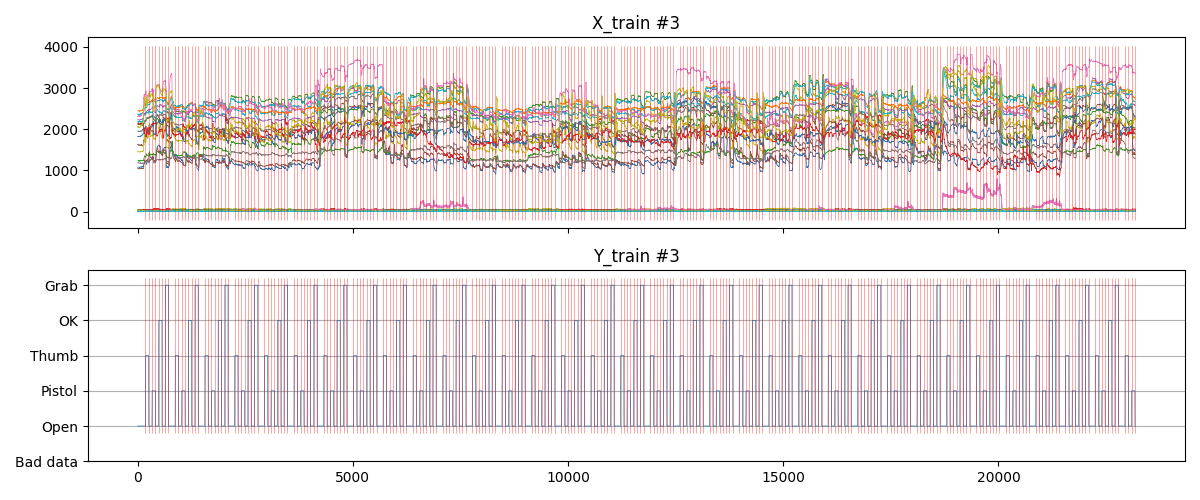

In [43]:
fig = figures.get_display_data(mounts=mounts, plot_counter='2-1')
print('Логгируем исходные данные')
#experiment.log_image('/gesture_classification/logs_and_figures/fig_2-1.png') # логгируем картинку 

### Data preparations for Neural Networks

In [44]:
SFREQ = 1000.0 / 33

for mount_name, mount in mounts.items():
    X_train = mount['X_train'] 
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(X_train.shape[1]).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.


In [45]:
for mount_name, mount in mounts.items():
    raw = mount['raw']
    y_train = mount['y_train']

    # выбор индексов, где происходит изменение жеста    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]

    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1, 
        tmax=1*2.5, 
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    y_train_nn = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_nn'] = X_train_nn
    mount['y_train_nn'] = y_train_nn

    print(f"{X_train_nn.shape, y_train_nn.shape}\n")

Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 107 original time points ...
1 bad epochs dropped
((276, 107, 50), (276, 107, 5))

Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 107 original time points ...
1 bad epochs dropped
((263, 107, 50), (263, 107, 5))

Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 268 events and 107 original time points ...
1 bad epochs dropped
((267, 107, 50), (267, 107, 5))



### Additional functions

### Model architecture (SimpleRNN)

In [46]:
model = SimpleRNN_Model(X_train_nn, y_train_nn, units=config['simpleRNN_units']).build_model()

print(type(model))

input_shape = (None, 50) | output_units = 5
Model: "model_SRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 50)]        0         
                                                                 
 batch_normalization (BatchN  (None, None, 50)         200       
 ormalization)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         15100     
                                                                 
 batch_normalization_1 (Batc  (None, None, 100)        400       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, None, 5)           505       
                                                                 
Total params

### Model train (SimpleRNN)

In [47]:
# Создаем словарь, в котором будем накапливать предсказания SimpleRNN на X_train 
# при разных validation_split в m.fit
x_trn_pred_dict = dict(zip(list(mounts.keys()), [[],[],[]]))
            
for splt_coef in range(10,100,25): # кол-во разных тренировок зависит от числа разбиений.
    
    val_splt_coef = splt_coef/100
    
    for mount_name, mount in mounts.items():
        
        X_train_nn = mount['X_train_nn']
        y_train_nn = mount['y_train_nn']
        
        tf.keras.backend.clear_session()
        reset_random_seeds(seed_value=config.seed_value) # сброс и задание random seed
        model = tf.keras.models.clone_model(model)
        
        model.compile(
            loss="mean_squared_error", 
            metrics=[f1], 
            optimizer='Adam', # по умолчанию learning rate=10e-3
        )
        
        history = model.fit(
            X_train_nn, 
            y_train_nn, 
            validation_split=val_splt_coef, 
        #-----------------------------
        #
        #      было 500 эпох
        #
        #-----------------------------            
            epochs=300,
            verbose=1
            callbacks=callbacks( 
                reduce_patience=config.reduce_patience, 
                stop_patience=config.stop_patience, 
                num_train=mount_name,
                
                PATH_BEST_MODEL=config.PATH_TEMP_MODEL,
                monitor=config.ModelCheckpoint.monitor, 
                verbose=config.ModelCheckpoint.verbose, 
                mode=config.ModelCheckpoint.mode, 
                save_best_only=config.ModelCheckpoint.save_best_only,

                restore_best_weights=config.EarlyStopping.restore_best_weights,
                
                factor=config.ReduceLROnPlateau.factor, 
                min_lr=config.ReduceLROnPlateau.min_lr_coeff
            ),  # остальные параметры - смотри в functions.py

        )
        
        #experiment.log_parameter("callbacks", callbacks) # логгируем  callbacks
        
        y_pred_train_nn = model.predict(X_train_nn)  #m.predict(X_train_nn) 
        print(y_pred_train_nn.shape)
        
        mount['model'] = model
        
        mount['y_pred_train_nn'] = y_pred_train_nn
        x_trn_pred_dict[mount_name].append(y_pred_train_nn)

# скрыть ход обучения модели
clear_output(wait=False)

Epoch 1/500
8/8 [==============================] - ETA: 0s - loss: 0.2576 - f1: 0.4175
Epoch 1: val_f1 improved from -inf to 0.40476, saving model to ../models/weights_best_model\best_model_rnn_1.hdf5
8/8 [==============================] - 2s 106ms/step - loss: 0.2576 - f1: 0.4175 - val_loss: 0.2676 - val_f1: 0.4048 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 0.2136 - f1: 0.5038
Epoch 2: val_f1 did not improve from 0.40476
8/8 [==============================] - 1s 67ms/step - loss: 0.2136 - f1: 0.5038 - val_loss: 0.2619 - val_f1: 0.4047 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - ETA: 0s - loss: 0.1895 - f1: 0.5490
Epoch 3: val_f1 did not improve from 0.40476
8/8 [==============================] - 1s 67ms/step - loss: 0.1895 - f1: 0.5490 - val_loss: 0.2664 - val_f1: 0.4048 - lr: 0.0010
Epoch 4/500
8/8 [==============================] - ETA: 0s - loss: 0.1721 - f1: 0.5915
Epoch 4: val_f1 did not improve from 0.40476
8/8 [==========

KeyboardInterrupt: 

In [ ]:
# смотрим размерность Pilot_id=1, наблюдения 1 (для примера)
x_trn_pred_dict[1][0].shape

(276, 107, 5)

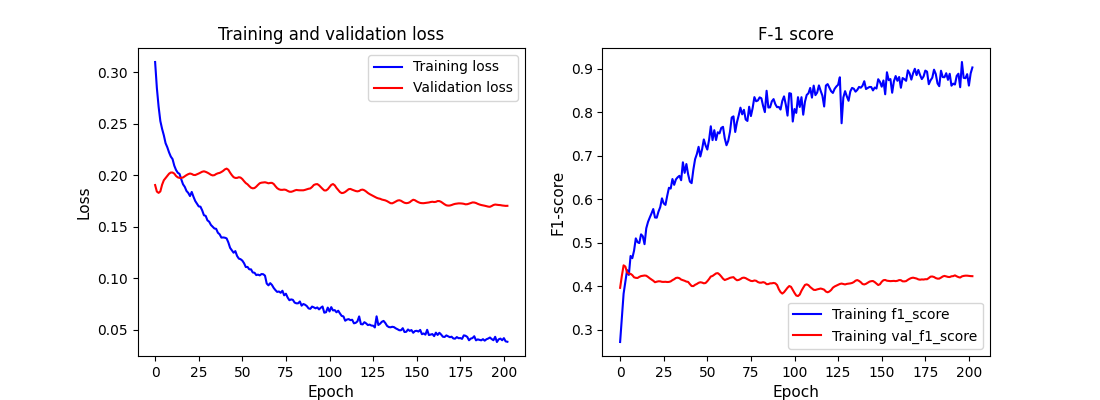

In [ ]:
# Визуализируем ход обучения модели #1
figures.plot_history(history, plot_counter='2-3')
#experiment.log_figure(figure_name='fig_2-3') # логгируем график

### Visualisation SimpleRNN predictions

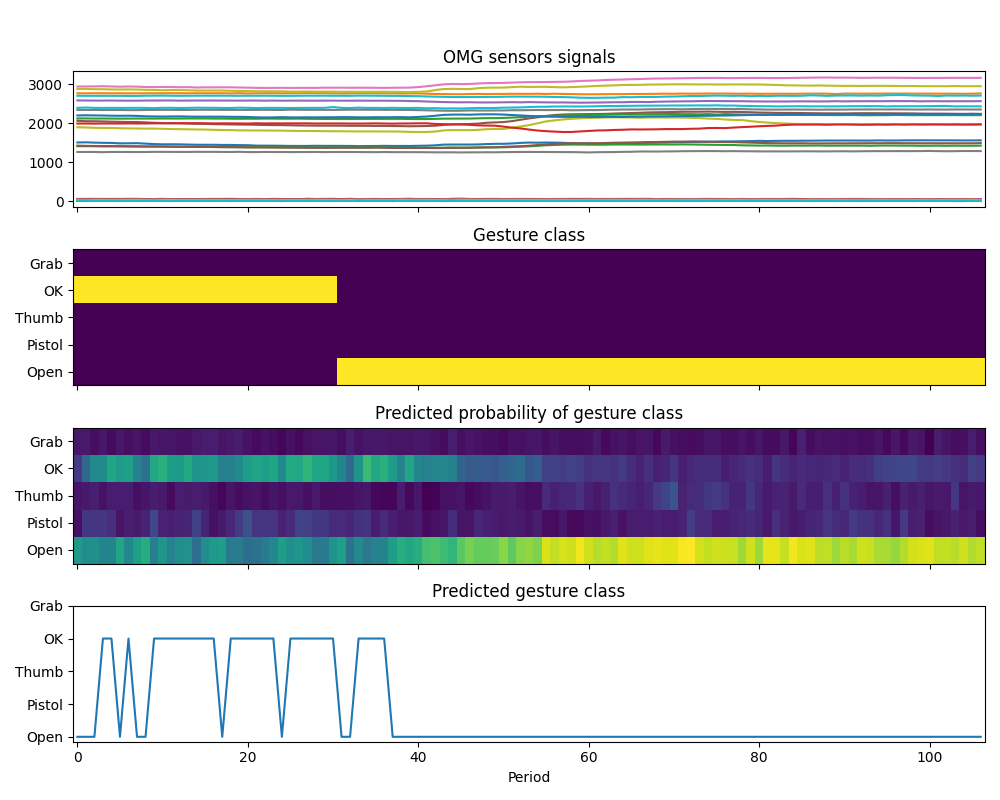

In [27]:
# Отображение предсказания моделью SimpleRNN
Pilot_id=3
y_pred_train_nn = mount['y_pred_train_nn']
y_pred_train_nn_mean = np.mean(x_trn_pred_dict[Pilot_id], axis=0)

figures.get_gesture_prediction_plot(
    Pilot_id=3, 
    i=5, 
    mounts=mounts, 
    y_pred_train_nn_mean=y_pred_train_nn_mean, 
    plot_counter='2-4'
)

#experiment.log_figure(figure_name='fig_2-4') # логгируем график

### Model architecture (LSTM)

In [28]:
model_lstm = LSTM_Model(X_train_nn, x_trn_pred_dict, lstm_units=config.lstm_units).build_model()

print(type(model_lstm))

input_shape = (None, 50) | output_units = 5
Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 50)]        0         
                                                                 
 batch_normalization (BatchN  (None, None, 50)         200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         80400     
                                                                 
 lstm_3 (LSTM)               (None, None, 100)         80400     
            

### Model train (LSTM)

In [29]:
# Смотрим размерность тренировочных данных перед подачей в модель LSTM для пилота 3
print(f"                        размерность тренировочных данных: {mounts[3]['X_train_nn'].shape}")

# Смотрим размерность целевой переменной перед подачей в модель LSTM для пилота 3
print(f"                          размерность целевой переменной: {mounts[3]['y_train_nn'].shape}") 

# Смотрим размерность усредненной предсказанной целевой переменной перед подачей в модель LSTM для пилота 3
# чтобы сравнить с размерностью целевой переменной (проверяем правильность)
print(f"размерность усредненной предсказанной целевой переменной: {np.mean(x_trn_pred_dict[3], axis=0).shape}") 

                        размерность тренировочных данных: (267, 107, 50)
                          размерность целевой переменной: (267, 107, 5)
размерность усредненной предсказанной целевой переменной: (267, 107, 5)


In [30]:
# Обучение модели LSTM на преобразованных данных y_train
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_pred_train_nn = np.mean(x_trn_pred_dict[mount_name], axis=0).argmax(axis=-1)
    y_pred_train_nn = tf.keras.utils.to_categorical(y_pred_train_nn)
    
    tf.keras.backend.clear_session()
    reset_random_seeds(seed_value=config.seed_value) # сброс и задание random seed
    m_lstm = tf.keras.models.clone_model(model_lstm)
    
    m_lstm.compile(
        loss="categorical_crossentropy",  
        metrics=[f1], 
        optimizer='Adam', # по умолчанию learning rate=10e-3
    )
    
    history2 = m_lstm.fit(
        X_train_nn,
        y_pred_train_nn,
        validation_split=0.2,
        
        #-----------------------------
        #
        #      было 1500 эпох
        #
        #-----------------------------
        epochs=50, #      
        verbose=1,
        callbacks=callbacks(
           
            reduce_patience=config.reduce_patience, 
            stop_patience=config.stop_patience, 
            
            PATH_BEST_MODEL=config.PATH_TEMP_MODEL,
            monitor=config.ModelCheckpoint.monitor, 
            verbose=config.ModelCheckpoint.verbose, 
            mode=config.ModelCheckpoint.mode, 
            save_best_only=config.ModelCheckpoint.save_best_only,

            restore_best_weights=config.EarlyStopping.restore_best_weights,
            
            factor=config.ReduceLROnPlateau.factor, 
            min_lr=config.ReduceLROnPlateau.min_lr_coeff,
            num_train=mount_name)  # остальные параметры - смотри в functions.py
    )
    
    mount['history2'] = history2
    
    mount['model_lstm'] = m_lstm

    # сохранение обученной модели в папке по пути PATH_FOR_MODEL в формате h5
    m_lstm.save(os.path.join(PATH_FOR_MODEL, 'model_lstm_' + str(mount_name) + '.h5'), save_format='h5')
    
    # Расчеты ниже нужны, чтобы посмотреть результат предсказания для модели LSTM на X_train_nn
    y_pred_train_lstm = m_lstm.predict(X_train_nn)
    print(y_pred_train_lstm.shape)
    mount['y_pred_train_lstm'] = y_pred_train_lstm

# скрыть ход обучения модели
clear_output(wait=False)

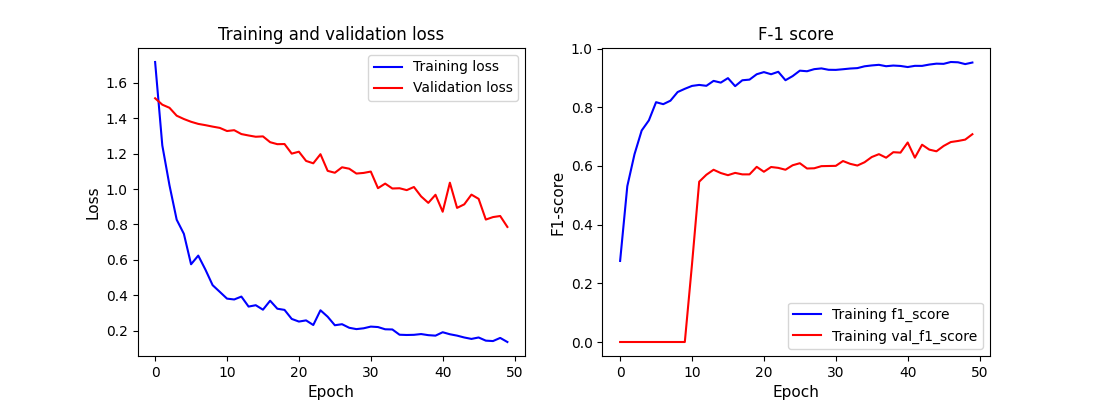

In [31]:
# Визуализируем ход обучения модели #2
figures.plot_history(history2, plot_counter='2-5') #mounts['history2']
#experiment.log_figure(figure_name='fig_2-5') # логгируем график

### Visualisation LSTM predictions

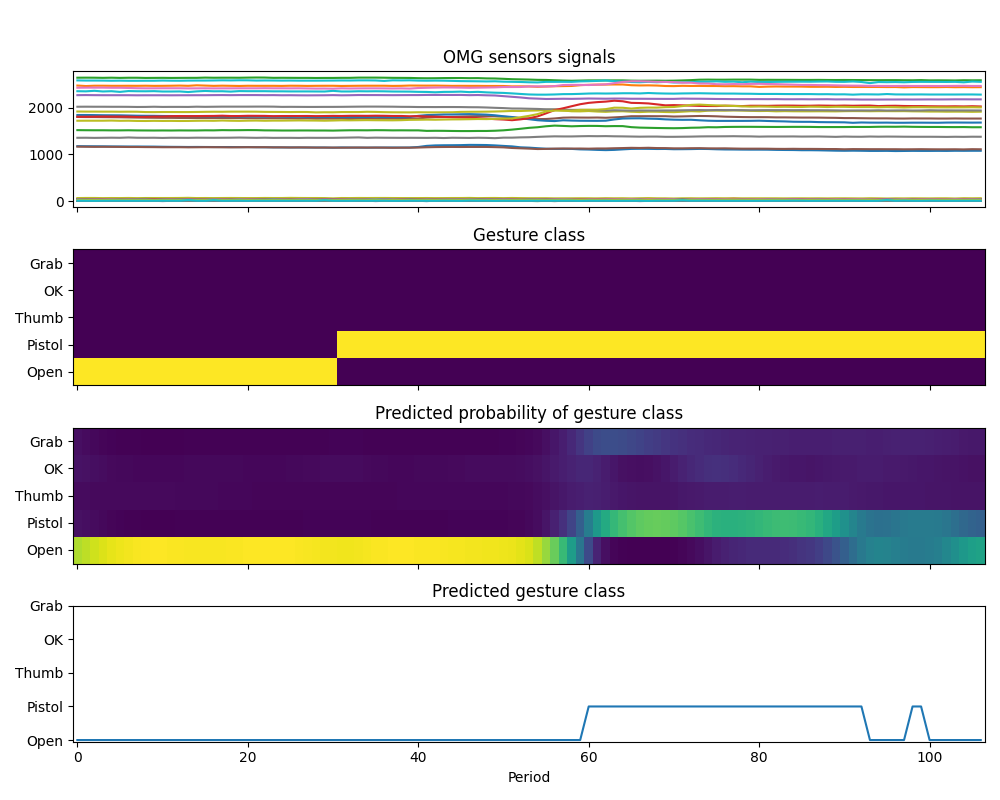

In [32]:
# Визуализируем предскание жеста моделью
Pilot_id=3 # номер пилота
y_pred_train_nn_mean = mount['y_pred_train_lstm']

figures.get_gesture_prediction_plot(
    Pilot_id=3, # номер пилота
    i=18, # номер наблюдения
    y_pred_train_nn_mean=y_pred_train_nn_mean, 
    mounts=mounts, # словарь
    plot_counter='2-6')

#experiment.log_figure(figure_name='fig_2-6') # логгируем график

### Predict test & submit with LSTM model

In [26]:
for mount_name, mount in mounts.items():
    
    #Чтение модели LSTM из словаря (после обучения модели LSTM)
    m_lstm = mount['model_lstm']

    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_lstm = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_lstm += [m_lstm.predict(X_test_i, verbose=0)]
        
    y_pred_test_lstm = [arr.argmax(axis=-1) for arr in y_pred_test_lstm]
    
    print(len(y_pred_test_lstm))
    assert len(y_pred_test_lstm) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_lstm'] = y_pred_test_lstm

899
855
861


In [27]:
# Объединяем результаты предсказания в один лист

y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test_lstm'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

# проверка соответствия размерности
assert y_pred_test_res.shape[0] == y_test.shape[0]

In [30]:
# Сохраняем результат предсказания модели в отдельный файл y_test_submit_rnn_LSTM.csv

y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('../logs_and_figures/y_test_submit_rnn_LSTM_2812.csv.zip', index=False)

y_test_submit

subject_id-sample-timestep  class
0                           1-0-0      0
1                           1-0-1      0
2                           1-0-2      0
3                           1-0-3      0
...                           ...    ...
471606                  3-860-177      0
471607                  3-860-178      0
471608                  3-860-179      0
471609                  3-860-180      0

[471610 rows x 2 columns]

In [ ]:
# Заканчиваем сессию логгирования эксперимента
#experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/alex1iv/gesture-classification/649b39242caa4896b24fe6ca573d9ab5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1 [4833]            : (0.08334998786449432, 0.9976634979248047)
COMET INFO:     batch_loss [4833]          : (0.00656526256352663, 2.3218278884887695)
COMET INFO:     epoch_duration [4833]      : (0.09300000010989606, 9.359999999869615)
COMET INFO:     f1 [4833]                  : (0.27226221561431885, 0.9948285222053528)
COMET INFO:     loss [4833]                : (0.01323469914495945, 1.7169468402862549)
COMET INFO:     lr [4833]                  : (0.00010941899381577969, 0.0010000000474974513)
COMET INFO:     val_f1 [4833]              : (0.0, 0.9366275072097778)
COMET INFO:     val_loss [4833]            : (0.0534

In [ ]:
# отображаем результат обучения
experiment.display()

### Обсуждение результата

Как было показано выше, работа над моделью состояла из двух основных этапов:
- получение на данных X_train разметки y_train, соответствующей моменту совершения жеста;
- обучение итоговой модели на данных X_train и корректированной разметки y_train для последующего предикта на тестовых данных.  

Качество обучения итоговой модели оценивалось по score на Leaderboard, как основному критерию. Предварительно рассматривались результаты предсказания обученной модели для данных X_train.  

За основу итоговой модели (для предикта тестовых данных) была взята нейронная сеть с четырьмя слоями LSTM библиотеки Keras. Для повышения качества обучения рассматривалось: изменение количества слоев LSTM, добавление/исключение слоев BatchNormalization, Dropout и Dense и вариация их параметров и др. Дополнительно использовались встроенные функции callbacks библиотеки Keras, а также варьировалась доля валидационной выборки при обучении модели.

В ноутбуке выше приведена итоговая архитектура модели LSTM, которая стабильно показывала результат, близкий к максимально возможному.  

В ходе выбора архитектуры модели нашей командой и сравнения с результатами score на Leaderboard других команд мы пришли к выводу, что для выбранного метода обучения существует некий порог точности предсказаний на представленных данных, который соответствует примерно score 0.7 на Leaderboard (score при предсказании разными моделями в основном попадал в интервал 0.65 - 0.69, а порог 0.7 так и не был преодолён).  

Сравнение результатов предсказаний наших лучших моделей показало, что они совпадают, в среднем, на 80%. При этом на определенном участке одна модель, к примеру, предсказывала 40 временных единиц, заполненных классом 4, а другая определяла на том же участке одну часть, заполненную классом 1, потом интервал, заполненный классом 4, потом еще интервал - снова класс 1. А на другом участке картина была обратная: вторая модель отработала стабильнее. Таким образом, следуя принципу временных причинно-следственных связей, мы не смогли в режиме реального времени выбрать, какая из тестируемых моделей на конкретном жесте отработала лучше. Такой вывод можно сделать только постфактум. Длина участка с расхождениями могла составить более 10 временных единиц, т.е. постобработка с "запаздыванием" на несколько временных единиц также не добавила бы определенности. Предполагается, что улучшение предсказания можно получить, усреднив предсказания вероятностей классов тремя оптимальными моделями LSTM.  


Основная задача первого этапа заключалась в обучении модели предсказывать классы (жесты) в текущий момент времени по показаниям датчиков и получать момент выполнения жеста (ступеньку на графике y_train) фиксируя момент изменения класса (получение на данных X_train скорректированной разметки y_train).  

Для определения классов нами были протестированы разные модели и архитектуры нейронных сетей библиотеки Keras. Сложная модель SRNN, например, c несколькими слоями SRNN, подстраивала предсказания классов под момент времени, 
соответствующий моменту подачи сигнала манипулятором. Поэтому такая модель давала ошибочные предсказания.

В качестве выборки для обучения других моделей подавались участки X_train двух типов: 
- включающие момент выполнения жеста, 
- участки, где жест оставался неизменным.
 
Однако, модели ошибочно предсказывали отсутствие изменения классов на участках обоих типов.

Поэтому для решения вышеописанной проблемы было решено использовать нейронную сеть SimpleRNN с простой архитектурой и обучать её на различных долях валидационной выборки (применение различных validation_split). Ошибки работы такой модели можно корректировать с помощью усреднения вероятностей предсказаний классов по рассматриваемым validation_split. Это позволит получить корректирующую разметку для последующего обучения более сложной модели (модели со слоями LSTM).

Также проводился анализ влияния корректировки разметки данных на качество предсказания, заключавшийся в следующем: 
- удаление "битых" данных из X_train второго пилота и отдельных выбросов в предсказании y_train; 
- приведение предсказания класса жеста к виду, установленному в протоколе: два класса жеста, разделенных "ступенькой"; 
- подстановка правильных классов в тех эпохах, где SimpleRNN ошиблась в классификации жестов. 

Однако, указанные преобразования не привели к повышению качества предсказаний итоговой модели LSTM. 

Дополнительно нужно отметить, что более 80% ошибок при классификации жестов моделью SimpleRNN заключалось в не распознавании отличия жеста "2" (сгиб большого пальца) от жеста "0" ("open"). Вероятно, показания датчиков этих двух жестов похожи. Поэтому рекомендуется изменить положения оптомиографических датчиков и провести повторный анализ.